In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import tqdm
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, lil_matrix, coo_matrix
from functools import partial

from tree_extraction import Aho
from compute_pam import compute_combo_tensor, get_alpha
from sim_data import HPAM2Sampler
from example_graphs import make_tree
from utils import bfs_layout, invert_permutation, permute_square

In [2]:
import sys, os
sys.path.append(os.path.abspath('../anchor-word-recovery/'))

In [3]:
from learn_topics import Analysis

In [4]:
np.random.seed(1)

In [5]:
def nice_tree_plot(t, ax = None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    if t is None:
        return
    draw_kwargs = dict(with_labels=True, pos=bfs_layout(t))
    draw_kwargs.update(kwargs)
    nx.draw(t, **draw_kwargs)

In [6]:
#tree = make_tree([3,3,3])
tree = make_tree([3,3])

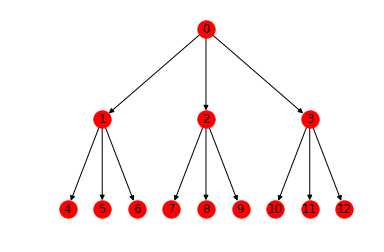

In [7]:
nice_tree_plot(tree)

## Extracting a tree from simulated data

In [8]:
num_docs = 50000
words_per_doc = 20
vocab_size = 100
topic_dirichlet = 0.1

In [9]:
def topic_func(node_id):
    topic = np.ones(vocab_size)
    topic[node_id % vocab_size] = 20.0
    topic /= topic.sum()
    return topic

#topic_func = None  # Use this line to use random topics instead

In [10]:
alpha_func = partial(get_alpha, pexit=0.3, scale=1.0, add_exit_edge=True)

In [11]:
sampler = HPAM2Sampler(
    g = tree,
    num_docs = num_docs,
    words_per_doc = words_per_doc,
    vocab_size = vocab_size,
    alpha_func = alpha_func,
    topic_dirichlet = topic_dirichlet,
    topic_func = topic_func)

In [12]:
%%time
sampler.sample(); None

100%|██████████| 50000/50000 [02:12<00:00, 376.92it/s]

CPU times: user 1min 53s, sys: 5.68 s, total: 1min 59s
Wall time: 2min 12s


In [13]:
%%time
data = lil_matrix((sampler.num_docs, sampler.vocab_size), dtype='float')
for doc_index, doc in enumerate(tqdm.tqdm(sampler.docs)):
    doc = sorted(doc)
    for vocab_index in doc:
        data[doc_index, vocab_index] += 1
data = csr_matrix(data)

100%|██████████| 50000/50000 [00:10<00:00, 4659.12it/s]


CPU times: user 10 s, sys: 278 ms, total: 10.3 s
Wall time: 11 s


In [14]:
num_digits = len(str(sampler.vocab_size - 1))
vocab = ["w{:0{}d}".format(i, num_digits) for i in range(sampler.vocab_size)]

In [15]:
K = len(tree.nodes())

In [16]:
analysis = Analysis(
    infile = data.copy().transpose(),
    vocab_file = vocab,
    outfile = None,
    loss = "L2",
    K = K,
    seed = 100,
    eps = 1e-6,
    new_dim = 1000,
    max_threads = 8,
    anchor_thresh = min(int(num_docs * 0.05), 50),
    top_words = 10,
)

In [17]:
%%time
analysis.run();

Input matrix shape: (100, 50000)
identifying candidate anchors
100 candidates
Sum of entries in Q is  0.9999999999999876
Multiplying Q took  1.2980589866638184 seconds
Q sum is 0.9999999999999876
done reading documents
anchors are:
0 w00
1 w02
2 w01
3 w03
4 w04
5 w11
6 w08
7 w06
8 w12
9 w07
10 w05
11 w10
12 w09
begin threaded recovery with 8 processors
0	-1	1.0
done recovering
w00 : w00 w20 w59 w14 w27 w26 w37 w86 w79 w48 
w02 : w02 w81 w71 w46 w52 w32 w84 w68 w83 w58 
w01 : w01 w95 w72 w68 w73 w44 w54 w61 w43 w88 
w03 : w03 w47 w46 w20 w49 w56 w26 w72 w71 w55 
w04 : w04 w25 w17 w78 w71 w64 w51 w70 w13 w18 
w11 : w11 w99 w75 w68 w37 w96 w38 w76 w63 w54 
w08 : w08 w50 w33 w24 w28 w90 w65 w75 w31 w21 
w06 : w06 w77 w87 w30 w32 w98 w61 w69 w49 w56 
w12 : w12 w35 w31 w70 w51 w30 w21 w95 w59 w50 
w07 : w07 w25 w43 w74 w86 w87 w49 w63 w42 w28 
w05 : w05 w29 w67 w82 w99 w16 w34 w98 w53 w14 
w10 : w10 w29 w44 w26 w42 w63 w25 w24 w81 w14 
w09 : w09 w19 w78 w26 w76 w85 w77 w13 w87 w62 
CPU times

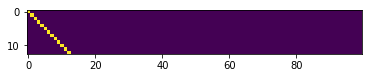

In [18]:
topics = np.array([sampler.topics[n] for n in tree.nodes()])
plt.imshow(topics);

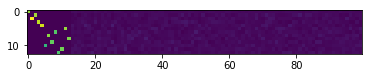

In [19]:
plt.imshow(analysis.A.T);

In [20]:
R = analysis.R

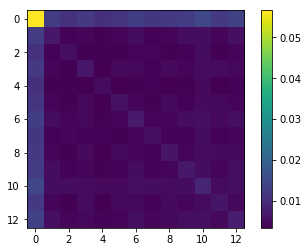

In [21]:
fig, ax = plt.subplots()
ax.imshow(R);
fig.colorbar(ax.get_images()[0]);

In [22]:
np.max(np.abs(R - R.T))

1.734723475976807e-17

In [23]:
R.min(), R.max()

(0.0033483093783044917, 0.05661893844418099)

In [24]:
R.sum()

1.000027404584242

In [25]:
C = Aho.get_ratio_matrix(R)

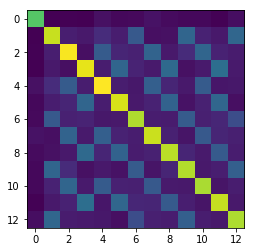

In [26]:
plt.imshow(C);

In [27]:
analysis.A.shape

(100, 13)

In [28]:
def extract_planted_topic_permutation(A, true_topics):
    V, K = A.shape
    indices = np.arange(K)
    A = A.copy()
    perm = []
    for i in range(K):
        target = true_topics[:, [i]]
        ii = np.argmin(np.sum(np.abs(A - target), axis=0))
        perm.append(indices[ii])
        indices = np.concatenate([indices[:ii], indices[ii+1:]])
        A = np.concatenate([A[:, :ii], A[:, ii+1:]], axis=1)
    return np.asarray(perm)

In [29]:
perm = extract_planted_topic_permutation(analysis.A, true_topics = topics.transpose())

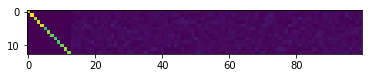

In [30]:
plt.imshow(analysis.A.T[perm, :]);

In [31]:
Rp = permute_square(analysis.R, perm = perm)

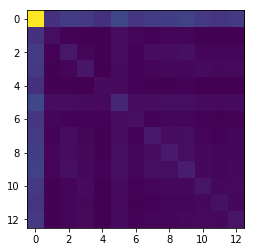

In [32]:
plt.imshow(Rp);

In [33]:
Cp = permute_square(C, perm=perm)

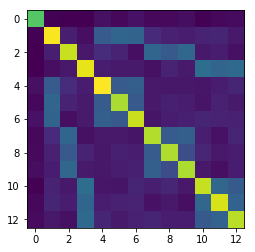

In [34]:
plt.imshow(Cp);

In [35]:
all_constraints = Aho.get_constraints(C = Cp, threshold = -np.inf)

In [36]:
expected_max_constraints = (K * (K - 1) // 2) * (K - 2)
expected_max_constraints

858

In [37]:
assert len(all_constraints) == expected_max_constraints

In [38]:
i, j, k = all_constraints[-1][:3]
all_constraints[-1]

TripletConstraint(i=3, j=0, k=10, strength=-0.22503619103813077)

In [39]:
Cp[i,j], Cp[i,k], Cp[j,k]

(0.8969203515661958, 1.1219565426043265, 0.8983419697580952)

In [40]:
Cp[i,j] - Cp[i,k], Cp[i,j] - Cp[j,k]

(-0.22503619103813077, -0.0014216181918994542)

In [41]:
extracted_tree = Aho.extract(Rp, threshold=1e-10)

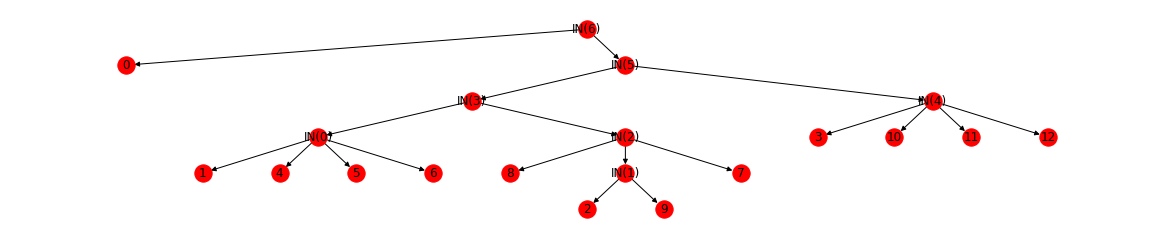

In [42]:
fig, ax = plt.subplots(figsize = (20,4))
nice_tree_plot(extracted_tree, ax=ax)

In [43]:
R_exact = compute_combo_tensor(tree, alpha_func=alpha_func)

In [44]:
C_exact = Aho.get_ratio_matrix(R_exact)

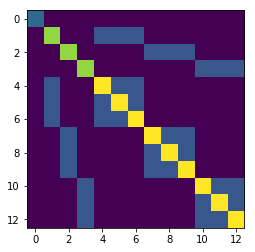

In [45]:
plt.imshow(C_exact);

In [46]:
expected_tree = Aho.extract(R_exact, threshold=1e-10)

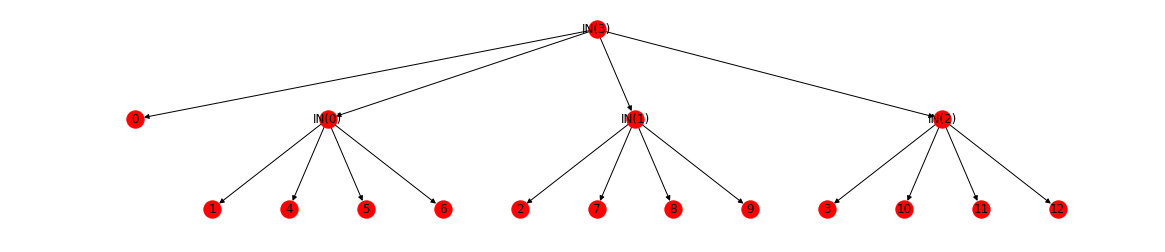

In [47]:
fig, ax = plt.subplots(figsize = (20,4))
nice_tree_plot(expected_tree, ax=ax)

In [48]:
all_constraints_exact = Aho.get_constraints(C_exact, threshold = -np.inf)
len(all_constraints_exact)

858

In [49]:
import pandas as pd
from collections import OrderedDict
from IPython.display import HTML

In [50]:
constraint_compare = []
for i in range(K):
    for j in range(i):
        for k in range(K):
            if k == i or k == j:
                continue
            rounder = lambda x: np.round(x, decimals = 5)
            exaC = [C_exact[i, j], C_exact[i, k], C_exact[j, k]]
            estC = [Cp[i, j], Cp[i, k], Cp[j, k]]
            exaStrength = min(exaC[0] - exaC[1], exaC[0] - exaC[2])
            estStrength = min(estC[0] - estC[1], estC[0] - estC[2])
            constraint_compare.append(OrderedDict([
                ("i", i), ("j", j), ("k", k),
                ("strength_exact", rounder(exaStrength)),
                ("strength_estimated", rounder(estStrength)),
                ("exaC_ij", rounder(exaC[0])),
                ("exaC_ik", rounder(exaC[1])),
                ("exaC_jk", rounder(exaC[2])),
                ("estC_ij", rounder(estC[0])),
                ("estC_ik", rounder(estC[1])),
                ("estC_jk", rounder(estC[2])),
            ]))
constraint_compare = pd.DataFrame.from_records(constraint_compare)
constraint_compare.sort_values(by="strength_exact", ascending=False, inplace=True)
constraint_compare.reset_index(drop = True, inplace = True)
constraint_compare.sort_values(by="strength_estimated", ascending=False, inplace=True)

HTML(constraint_compare.to_html(max_rows=20))

,i,j,k,strength_exact,strength_estimated,exaC_ij,exaC_ik,exaC_jk,estC_ij,estC_ik,estC_jk
22,10,3,0,0.52571,0.22361,1.32571,0.80000,0.80000,1.12196,0.89834,0.89692
147,12,3,0,0.52571,0.19461,1.32571,0.80000,0.80000,1.10781,0.91320,0.89692
38,11,10,0,0.52571,0.19269,1.32571,0.80000,0.80000,1.10149,0.90879,0.89834
8,5,1,0,0.52571,0.19180,1.32571,0.80000,0.80000,1.09966,0.90785,0.89865
20,7,2,0,0.52571,0.18969,1.32571,0.80000,0.80000,1.09875,0.90905,0.89554
80,11,3,0,0.52571,0.18896,1.32571,0.80000,0.80000,1.09775,0.90879,0.89692
134,9,2,0,0.52571,0.18370,1.32571,0.80000,0.80000,1.10129,0.91758,0.89554
35,10,3,2,0.52571,0.18334,1.32571,0.80000,0.80000,1.12196,0.93861,0.93734
27,10,3,5,0.52571,0.18200,1.32571,0.80000,0.80000,1.12196,0.93046,0.93996
133,10,3,9,0.52571,0.18026,1.32571,0.80000,0.80000,1.12196,0.93816,0.94170


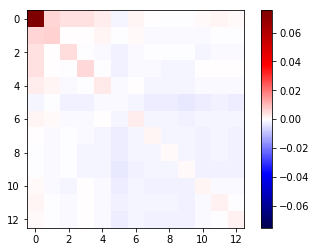

In [51]:
v = np.max(np.abs(R_exact - Rp))
plt.imshow(R_exact - Rp, vmin=-v, vmax=v, cmap='seismic');
plt.colorbar();

In [52]:
R_exact.sum(), Rp.sum(), R_exact[0,0], Rp[0,0]

(1.0, 1.0000274045842419, 0.13200000000000003, 0.05661893844418099)

Need to diagnose results...
* incorrect topics?  (how to map recovered topics onto "expected" topics?)
  * topics with too much overlap?
    * try sparser dirichlet?
    * or try fixed topics, chosen specifically to have low overlap (this makes it easier to map recovered to expected)
* or: correct topics but noisy R estimation?  (throwing away too many triplets??)

To deal with noisy R estimation, may need to adapt algorithm to optimize some cost function
that treats triplets as soft constraints; optimize some kind of "cost function" at each recursive split.

## Extraction applied to real data

In [53]:
corpus_matrix_file = "../anchor-word-recovery/M_nips.full_docs.mat.trunc.mat"
vocab_file = "../anchor-word-recovery/vocab.nips.txt.trunc"

In [54]:
analysis = Analysis(
    infile = corpus_matrix_file,
    vocab_file = vocab_file,
    outfile = None,
    loss = "L2",
    K = 15,
    seed = 100,
    eps = 1e-6,
    new_dim = 1000,
    max_threads = 8,
    anchor_thresh = 100,
    top_words = 10,
)

In [55]:
%%time
analysis.run();

Input matrix shape: (2940, 1500)
identifying candidate anchors
1735 candidates
Sum of entries in Q is  1.0
Multiplying Q took  1.9974219799041748 seconds
Q sum is 1.0
done reading documents
anchors are:
0 neuroscience
1 part
2 iii
3 cognitive
4 paul
5 science
6 architecture
7 theory
8 visual
9 processing
10 policy
11 head
12 speaker
13 spike
14 character
begin threaded recovery with 8 processors
0	73	0.3997861214540097
1000	47	0.20296322373079012
2000	69	0.22478639073903145
done recovering
neuroscience : neuroscience implementation application planning navigation control singh stephen andrew richard 
part : part algorithm control navigation planning signal speech chip system analog 
iii : iii application realization theories utility formalism implementation animal theoretic tishby 
cognitive : cognitive application implementation action agent control plan policies exploration boulder 
paul : david michael john richard peter index author thomas paul william 
science : science algorithm 

In [56]:
R = analysis.R

In [57]:
extracted_tree = Aho.extract(R, threshold = 1e-10)

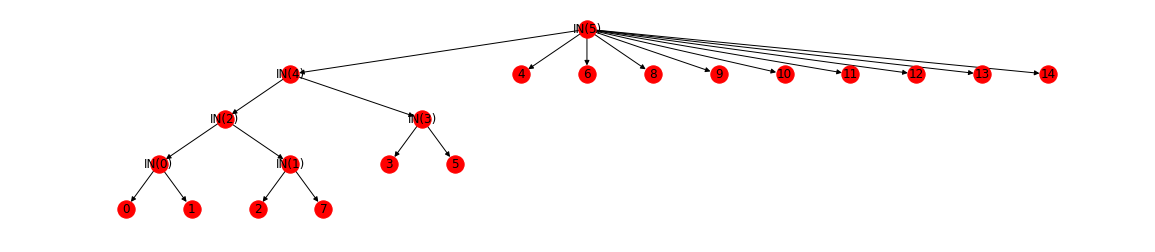

In [58]:
fig, ax = plt.subplots(figsize = (20,4))
nice_tree_plot(extracted_tree, ax=ax)

In [59]:
for i, t in enumerate(analysis.all_topwords):
    print("({}) {}:\n  {}".format(i, t.anchor_word, ", ".join(t.top_words)))

(0) neuroscience:
  neuroscience, implementation, application, planning, navigation, control, singh, stephen, andrew, richard
(1) part:
  part, algorithm, control, navigation, planning, signal, speech, chip, system, analog
(2) iii:
  iii, application, realization, theories, utility, formalism, implementation, animal, theoretic, tishby
(3) cognitive:
  cognitive, application, implementation, action, agent, control, plan, policies, exploration, boulder
(4) paul:
  david, michael, john, richard, peter, index, author, thomas, paul, william
(5) science:
  science, algorithm, application, control, unit, network, input, representation, set, level
(6) architecture:
  architecture, algorithm, network, unit, input, weight, neural, output, problem, function
(7) theory:
  theory, function, algorithm, network, data, set, neural, error, result, point
(8) visual:
  visual, signal, speech, image, object, neuron, field, system, motion, map
(9) processing:
  processing, signal, speech, control, system, 

## Examine SVD of $R$

In [60]:
u, s, vh = np.linalg.svd(R_exact)

In [61]:
vmax = max(np.max(np.abs(u)), np.max(np.abs(vh)))

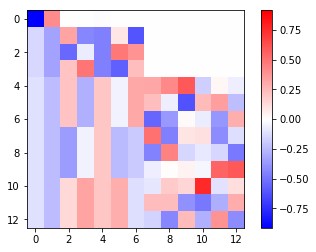

In [62]:
plt.imshow(u, vmin=-vmax, vmax=vmax, cmap='bwr');
plt.colorbar();

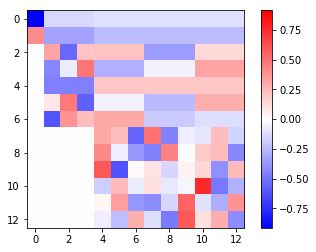

In [63]:
plt.imshow(vh, vmin=-vmax, vmax=vmax, cmap='bwr');
plt.colorbar();

In [64]:
np.max(np.abs(vh - u.T))

5.551115123125783e-16

In [65]:
s

array([0.153887  , 0.02311951, 0.01193639, 0.01193639, 0.00497037,
       0.00493828, 0.00493828, 0.00421037, 0.00421037, 0.00421037,
       0.00421037, 0.00421037, 0.00421037])

Note: with all other quantities kept constant, the number of documents required is essentially $O(1/\gamma^6)$, where $\gamma$ is the smallest singular value of $R$.  
Furthermore, the recovery of $A$ and $R$ becomes unstable when $\gamma$ is too small.

(Source: Theorem 1 in Arora et al, "Learning Topic Models -- Provably and Efficiently")

In [66]:
int(1 / np.min(s)**6)

179505680067395

In [67]:
int(1 / np.max(s)**6)

75298

## Trying to recover $R$ matrix via variational inference based on LDA model

In [68]:
import simple_hierarchical_topic_model as shtm

In [69]:
lda_vi = shtm.SimpleHierarchicalTopicModel(vocab = vocab, paths = [(i,) for i in range(K)], prior_params_DL = 10.0)

In [70]:
lda_vi.fit(data = data.transpose());

  2%|▏         | 9/500 [02:16<1:43:13, 12.61s/it, Status=computing statistics]


In [71]:
assign_L = np.argmax(lda_vi.var_params_L, axis=1)

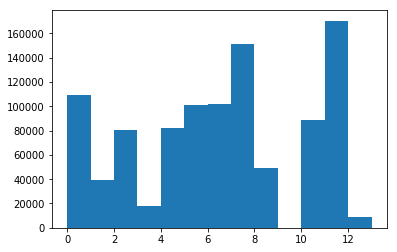

In [72]:
plt.hist(assign_L, bins=np.arange(K+1));

In [73]:
cooccurrence_lda_vi = np.zeros((K, K))
for doc_index in range(num_docs):
    lo = lda_vi.token_offsets_by_document[doc_index]
    hi = lda_vi.token_offsets_by_document[doc_index + 1]
    for i in range(lo, hi, 2):
        cooccurrence_lda_vi[assign_L[i], assign_L[i + 1]] += 1
        #cooccurrence_lda_vi[assign_L[i + 1], assign_L[i]] += 1
R_lda_vi = (0.5 * cooccurrence_lda_vi + 0.5 * cooccurrence_lda_vi.T) / cooccurrence_lda_vi.sum()
del cooccurrence_lda_vi
R_lda_vi.shape

(13, 13)

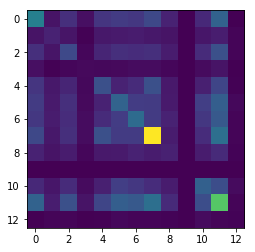

In [74]:
plt.imshow(R_lda_vi);

In [75]:
C_lda_vi = Aho.get_ratio_matrix(R_lda_vi)

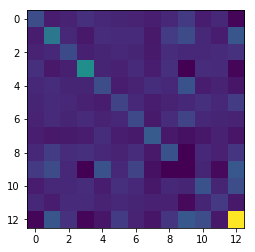

In [76]:
plt.imshow(C_lda_vi);

In [77]:
A_lda_vi = lda_vi.get_expected_topic_vectors()

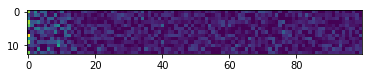

In [78]:
plt.imshow(A_lda_vi);

In [79]:
from importlib import reload
import simple_hierarchical_topic_model
reload(simple_hierarchical_topic_model)
import simple_hierarchical_topic_model as shtm
del simple_hierarchical_topic_model